Load and prepare data:

In [1]:
from data_minimization_benchmark.datapreparers import GSSDataPreparer

gss_data = GSSDataPreparer().prepare()

Now create and train target classifier models:

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

random_forest = RandomForestClassifier(random_state=14)
random_forest.fit(*gss_data.encoded_data.model_train)
mlp = MLPClassifier(random_state=14)
mlp.fit(*gss_data.encoded_data.model_train)

target_models = {"Random Forest": random_forest, "MLP": mlp}

Create and fit SHAP minimizer to get the shap order of the features. Or use precalculated order:

In [3]:
from apt.minimization import ShapMinimizer, OrderedFeatureMinimizer, GeneralizeToRepresentative
shap_ordered_features = None
shap_ordered_features = ['Race', 'Gender', 'X_rated', 'Children', 'Work status', 'Age', 'Happiness']

if shap_ordered_features is None:
    shap_minimizer = ShapMinimizer(
        random_forest, gss_data.encoder,
        categorical_features=gss_data.categorical_features,
        target_accuracy=1,
        background_size=20,
        n_samples=70,
        random_state=14
    )
    shap_minimizer.fit(*gss_data.unencoded_data.generalizer_train)
    shap_ordered_features = shap_minimizer.ordered_shap_features
shap_ordered_features

C:\Users\Mew\anaconda3\envs\apt36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mew\anaconda3\envs\apt36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mew\anaconda3\envs\apt36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mew\anaconda3\envs\apt36\lib\site-packages\tensorflow\python\framework

['Race', 'Gender', 'X_rated', 'Children', 'Work status', 'Age', 'Happiness']

Run benchmark on SHAP ordered minimizer

In [4]:
from data_minimization_benchmark.benchmark import Benchmark
from data_minimization_benchmark.utils.plotter import Plotter

import numpy as np
target_accuracies = np.arange(0, 1, 0.1,)

In [5]:
def create_shap_minimizer(*args, **kwargs):
    return OrderedFeatureMinimizer(*args, **kwargs, ordered_features=shap_ordered_features,
                                       data_encoder=gss_data.encoder, random_state=14)
shap_ordered_benchmark = Benchmark(
    # generalizer=OrderedFeatureMinimizer(random_forest, data_encoder=gss_data._encoder,
    #                                 categorical_features=gss_data.categorical_features,
    #                                 target_accuracy=0.8, ordered_features=ordered_shap_features),
    generalizer=create_shap_minimizer,
    train_set=gss_data.unencoded_data.generalizer_train,
    test_set=gss_data.unencoded_data.generalizer_validation,
    models=target_models,
    encoder=gss_data.encoder,
    target_accuracies=target_accuracies,
    features=gss_data.all_features,
    categorical_features=gss_data.categorical_features,
)
shap_benchmark_result = shap_ordered_benchmark.run()

Random Forest results:


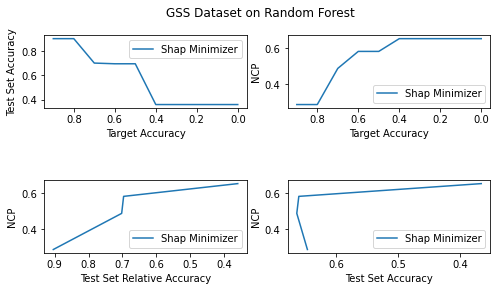

MLP results:


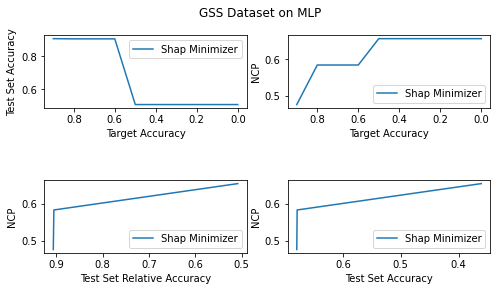

In [6]:
plotter = Plotter(results={"Shap Minimizer": shap_benchmark_result}, dataset="GSS")
for model in target_models:
    print(f"{model} results:")
    plotter.plot(model)

In [ ]:
    def single_dt_maker(*args, **kwargs):
        return GeneralizeToRepresentative(*args, **kwargs, encoder=gss_data.encoder)
    target_accuracies = np.arange(0, 0.8, 0.1)
    single_dt_benchmark = Benchmark(
        generalizer=GeneralizeToRepresentative,
        train_set=gss_data.unencoded_data.generalizer_train,
        test_set=gss_data.unencoded_data.generalizer_validation,
        models=target_models,
        encoder=gss_data.encoder,
        target_accuracies=target_accuracies,
        features=gss_data.all_features,
        categorical_features=gss_data.categorical_features,
    )
    single_dt_benchmark_result = single_dt_benchmark.run()
    single_dt_benchmark_result

Initial accuracy of model on generalized data, relative to original model predictions (base generalization derived from tree, before improvements): 0.808859
Improving generalizations
Pruned tree to level: 1, new relative accuracy: 0.808518
Pruned tree to level: 2, new relative accuracy: 0.807836
Pruned tree to level: 3, new relative accuracy: 0.807836
Pruned tree to level: 4, new relative accuracy: 0.806474
Pruned tree to level: 5, new relative accuracy: 0.806133
Pruned tree to level: 6, new relative accuracy: 0.801363
Pruned tree to level: 7, new relative accuracy: 0.798637
Pruned tree to level: 8, new relative accuracy: 0.794889
Pruned tree to level: 9, new relative accuracy: 0.790119
Pruned tree to level: 10, new relative accuracy: 0.779216
Pruned tree to level: 11, new relative accuracy: 0.776491
Pruned tree to level: 12, new relative accuracy: 0.772743
Pruned tree to level: 13, new relative accuracy: 0.755026
Pruned tree to level: 14, new relative accuracy: 0.762862
Pruned tree to

In [ ]:
plotter = Plotter(results={"Shap Minimizer": single_dt_benchmark_result, "Original Minimizer": single_dt_benchmark_result}, dataset="GSS")
for model in target_models:
    print(f"{model} results:")
    plotter.plot(model)